# Imports, loading the data, and basic cleaning + manipulation

### Edits made to dataset:
1. dropped the time, ID, and number of the race
2. renamed columns
3. edited the splits to be in seconds for easier manipulation
4. lengths have been edited (later)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mplt
import math
from scipy.stats import binom

df = pd.read_json('./henley1.json')

df.drop(columns = ['raceDateTime', 'id', 'number'], inplace = True)

df.rename(columns = {'trophy' : 'Trophy',
                     'round' : 'Round',
                     'winner' : 'Winner',
                     'loser' : 'Loser',
                     'withdrawn' : 'Withdrawn',
                     'station' : 'Winning Station',
                     'barrier' : 'Barrier Split',
                     'fawley' : 'Fawley Split',
                     'finish' : 'Finish Split',
                     'verdict': 'Verdict',
                     'raceDay' : 'Day',
                     'raceYear' : 'Year',
                     'raceTime' : 'Start Time'},
                     inplace = True)

df['Round'] = df['Round'].str.lower()
df['Round'] = df['Round'].str.replace('semi-finals', 'semi-final')

df['Barrier Split'] = df['Barrier Split'].astype('string')
df['Barrier (minutes)'], df['Barrier (seconds)'] = df['Barrier Split'].str.slice(stop = -3), df['Barrier Split'].str.slice(start = -2)
df['Barrier (minutes)'], df['Barrier (seconds)'] = pd.to_numeric(df['Barrier (minutes)'], errors = 'coerce'), pd.to_numeric(df['Barrier (seconds)'], errors = 'coerce')
df['Barrier Split (seconds)'] = (df['Barrier (minutes)'] * 60) + df['Barrier (seconds)']
df.drop(columns = ['Barrier (minutes)', 'Barrier (seconds)', 'Barrier Split'], inplace = True)

df['Fawley Split'] = df['Fawley Split'].astype('string')
df['Fawley (minutes)'], df['Fawley (seconds)'] = df['Fawley Split'].str.slice(stop = -3), df['Fawley Split'].str.slice(start = -2)
df['Fawley (minutes)'], df['Fawley (seconds)'] = pd.to_numeric(df['Fawley (minutes)'], errors = 'coerce'), pd.to_numeric(df['Fawley (seconds)'], errors = 'coerce')
df['Fawley Split (seconds)'] = (df['Fawley (minutes)'] * 60) + df['Fawley (seconds)']
df.drop(columns = ['Fawley (minutes)', 'Fawley (seconds)', 'Fawley Split'], inplace = True)

df['Finish Split'] = df['Finish Split'].astype('string')
df['Finish (minutes)'], df['Finish (seconds)'] = df['Finish Split'].str.slice(stop = -3), df['Finish Split'].str.slice(start = -2)
df['Finish (minutes)'], df['Finish (seconds)'] = pd.to_numeric(df['Finish (minutes)'], errors = 'coerce'), pd.to_numeric(df['Finish (seconds)'], errors = 'coerce')
df['Finish Split (seconds)'] = (df['Finish (minutes)'] * 60) + df['Finish (seconds)']
df.drop(columns = ['Finish (minutes)', 'Finish (seconds)', 'Finish Split'], inplace = True)

df.head()

,Trophy,Round,Winner,Loser,Withdrawn,Winning Station,Verdict,Day,Year,Start Time,...,Barrier ER,Barrier NR,Fawley LL,Fawley ER,Fawley NR,Finish ER,Finish NR,Barrier Split (seconds),Fawley Split (seconds),Finish Split (seconds)
0,Fawley,final,Leander Club 'A',Hinksey Sculling School 'A',0.0,2 - Bucks,3¾ Lengths,Sunday,2023,16:30,...,False,False,False,False,False,False,False,122.0,205.0,427.0
1,Britannia,final,Thames R.C. 'A',Molesey B.C.,0.0,1 - Berks,3¾ Lengths,Sunday,2023,16:20,...,False,False,False,False,False,False,False,126.0,212.0,440.0
2,Wargrave Challenge,final,Thames R.C. ’A’,Leander Club,0.0,2 - Bucks,2 Lengths,Sunday,2023,16:10,...,False,False,False,False,False,False,False,125.0,211.0,442.0
3,Hambleden,final,"R.E.S. Edwards & C.P.W. Brew, Leander Club","E.M. Lindberg & E.C. Witt, University of Londo...",0.0,2 - Bucks,1¾ Lengths,Sunday,2023,16:00,...,False,False,False,False,False,False,False,162.0,268.0,540.0
4,Stonor,final,"J. Moffatt & J. Casson, Shawnigan Lake School CAN","O.A. Obukohwo & K.S.A. George, Twickenham R.C....",0.0,2 - Bucks,2¼ Lengths,Sunday,2023,15:50,...,False,False,False,False,False,False,False,146.0,244.0,501.0


### To do Questions
 - does the time of day have any impact on the station result? YES
  - same for weather, same for tides?
 - what were the most exciting years/days (combine with closest margins and LL)
 - what are the most exciting events/race days? X
 - how has the closeness changed over the years?
 - how has the split time changed over the years?
 - in a given year, which days are the most unfair? do we see a huge amount being unfair on the friday but completely fair on the sunday, or rebalanced on the saturday?

### First Impressions?

1. There are 7179 rows, and 22 columns in the dataset
2. The data goes back to 1999, with a small a drop off in what was recorded the further back we go.
3. There was no event in 2020 (due to the pandemic)
4. In 2023 the number of race days increased by 1.
3. Between 1999 and 2015, the number of races held fairly steady, at an average of 281 with a variance of only 7.8 and a range of 26, but since then it has climbed, reaching 425 races in 2023. This bumps the average to 299 races per year with a variance of 37 and a range of 157.



### Which station wins the most?

My first question is about the different win rates of the two stations. We can below that the 'Berks' station wins more frequently than the 'Bucks' station. In only 3 of the 24 years does 'Bucks' win more often. The greatest raw differences are found in 2018 (64), 2023 (51), and 2019 (50). When we look at the greatest differences as a percentage of total races that year, the highest is still 2018, (60.5%), then 2001 (58.7%), and 2003 (58.2%).

<AxesSubplot: xlabel='Year', ylabel='Wins'>

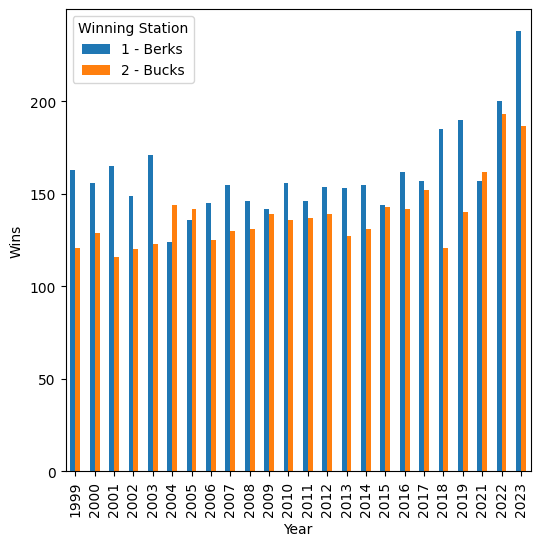

In [2]:
station_groupby = df.groupby(by = ['Year', 'Winning Station'])['Winning Station'].count()
station_groupby = station_groupby.unstack('Winning Station', 'Year')

fig_1, ax_1a = mplt.subplots()

station_groupby.plot(ax = ax_1a, kind = 'bar', figsize = (6,6), ylabel = 'Wins')

### Is this distribution significant?

Using scipy, we can see if this distribution of wins and losses is actually significant. For example, in 1999, Berks won 163 races out of 284. Using binom.pmf, we can see the probability mass of this distribution occurring is 0.2% - not particularly likely. Given that to find this result we have assumed an even probability of either station winning, this suggests that this is not a correct assumption. Looking at the wins over all years, we can see that the odds of Berks winning the number it has or more if the stations were fair is 4.7e-10 - exceedingly unlikely.

In [3]:
station_groupby['Berks % Wins'] = ((station_groupby['1 - Berks'] / (station_groupby['1 - Berks'] + station_groupby['2 - Bucks'])) * 100).round(1)
station_groupby['Bucks % Wins'] = ((station_groupby['2 - Bucks'] / (station_groupby['1 - Berks'] + station_groupby['2 - Bucks'])) * 100).round(1)

n_1999 = 163 + 121
p = 0.5
print('Odds of Berks winning 163 out of 284 races is', (binom.pmf(163, n_1999, p) * 100).round(2), '%')

n_overall = station_groupby['1 - Berks'].sum() + station_groupby['2 - Bucks'].sum()
berks_wins = station_groupby['1 - Berks'].sum()

print(f'Odds of Berks winning {berks_wins} or more out of {n_overall} races is', ((binom.pmf(range(berks_wins, n_overall + 1), n_overall, p)).sum()) * 100, '%')


Odds of Berks winning 163 out of 284 races is 0.21 %
Odds of Berks winning 3849 or more out of 7179 races is 4.791739494853054e-08 %


At this point, we are quite suspicious of the fairness of the two stations. If they conferred equal opportunity to win, we would expect (after so many iterations), that this would be a lot closer to a 50/50 distribution. We can plot the PMF, as below. On this graph, we can see the probability of any given number of Berks wins, as well as the red vertical line indicating the actual number of wins. We can be quite sure that the disproportionate result observed is significant.

/home/domigmr/.local/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


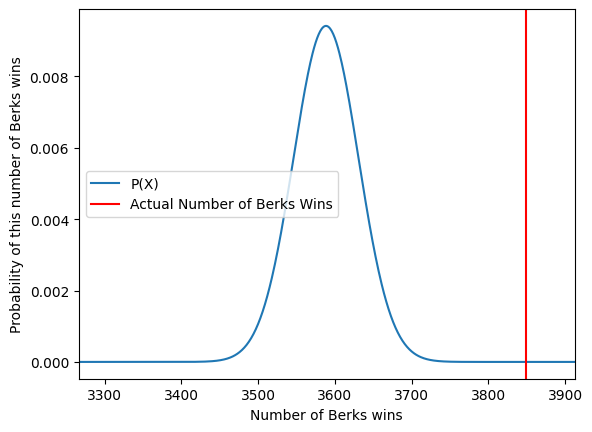

In [4]:
temp = pd.DataFrame(binom.pmf(range(1, n_overall + 1), n_overall, p), columns = ['P(X)'])

ax = temp.plot(column = ['P(X)'], ylabel = 'Probability of this number of Berks wins', xlabel = 'Number of Berks wins')
ax.set_xlim(n_overall*.455,n_overall*.545)
ax.axvline(x = berks_wins, color = 'r', label = 'Actual Number of Berks Wins')
ax.legend()

### Possible influences on uneven win rates

#### Time of Day

We might want to look at whether the time of day affects the chances of winning a race, but unfortunately most of the records just have '00:00' recorded as a start time. We only have records back to 2021 for start times, which amounts to 1137 races. Morning is before 12pm, afternoon is between 12pm and 5pm, and evening is after 5pm.

In [5]:
df['Start Time'] = (df['Start Time'].str.slice(start = 0, stop = 2)).astype(int)

def assign_tod(tod):
    if tod == 0:
        return None
    elif tod < 12:
        return 'morning'
    elif tod < 17:
        return 'afternoon'
    else:
        return 'evening'

df['ToD'] = df['Start Time'].apply(lambda x: assign_tod(x))
df['ToD'].value_counts()

afternoon    466
morning      382
evening      289
Name: ToD, dtype: int64

Interestingly, we can see that the as the day goes on, the overall victory is more likely to go to Berks whereas in the morning there is even a skew towards Bucks. Admittedly, 2021 and 2022 were both close years, with 2021 being one of the only ones in which Bucks had more wins. Note that I have divided the difference by the total number of races in that category to avoid skewing the data towards buckets with larger sizes. It will be interesting to examine how this relationship changes with further data.

<AxesSubplot: title={'center': 'Relative Difference in Wins for Time of Day'}, xlabel='Year', ylabel='Difference in Wins (positive = Berks win)'>

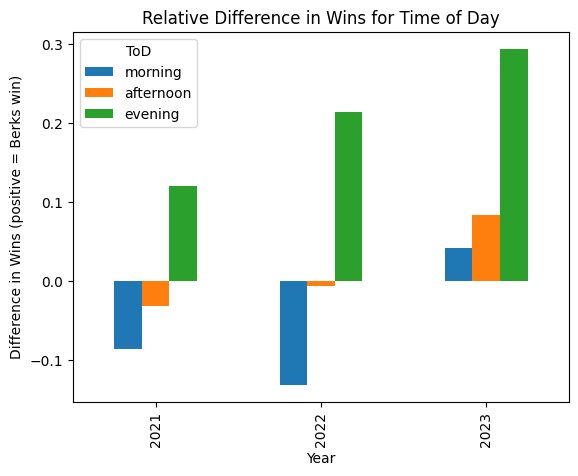

In [12]:
st_groupby = df.groupby(['Year', 'ToD', 'Winning Station'])['Winning Station'].count()
st_groupby = st_groupby.unstack('Winning Station', 'ToD').reindex(['morning', 'afternoon', 'evening'], level = 1)
st_groupby['Difference'] = (st_groupby['1 - Berks'] - st_groupby['2 - Bucks']) / (st_groupby['1 - Berks'] + st_groupby['2 - Bucks'])
st_groupby['Difference'].unstack().plot(kind = 'bar', title = 'Relative Difference in Wins for Time of Day', ylabel = 'Difference in Wins (positive = Berks win)')


#### Boat Class

We might think that some boat classes are more affected than others. For instance, single sculls (being lighter) suffer more in headwinds than eights. On the below graph, we can see the what relative quantity of races each station won for each boat class(1 being all won by Berks and -1 all won by Bucks). There isn't a huge amount of correlation in the data, and I'm not certain how to to do this quantively yet, but it looks like the heavier boats are slightly more likely to win on the Berks station. The M8+, the heaviest boat class, almost never has more losses on Bucks, whereas 4 out of 5 of the single and double-manned boats tend to win on Bucks more often.

This might be because heavier boats are able to a) capitalise on the advantage conferred by Berks, or b) are less affected by the disadvantage conferred by Bucks or c) both a and b.

The red line represents the mean win difference for each boat class. The yellow line represents the variance for each boat class. The blue horizontal represents the mean variance.

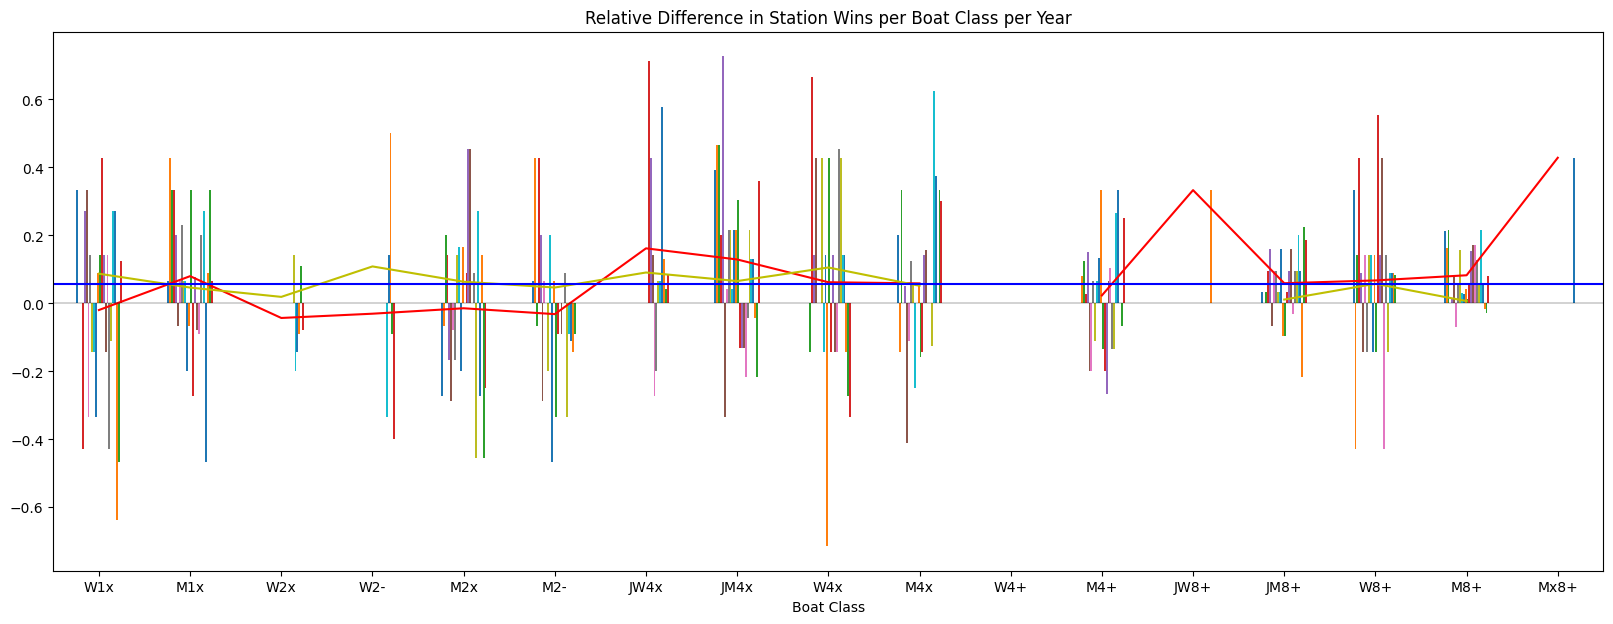

In [7]:
boat_class_weight_order = ['W1x', 'M1x','W2x','W2-','M2x','M2-','JW4x','JM4x','W4x','M4x', 
                           'W4+','M4+', 
                           'JW8+', 'JM8+',
                           'W8+','M8+',
                           'Mx8+']

boatclass_gb = df.groupby(['Year', 'Boat Class', 'Winning Station'])['Winning Station'].count()
boatclass_gb = boatclass_gb.unstack()

boatclass_gb['Difference'] = (boatclass_gb['1 - Berks'] - boatclass_gb['2 - Bucks']) / (boatclass_gb['1 - Berks'] + boatclass_gb['2 - Bucks'])
boatclass_gb = boatclass_gb['Difference'].unstack()
boatclass_gb = boatclass_gb.reindex(columns = boat_class_weight_order)
boatclass_gb = boatclass_gb.transpose()

ax = boatclass_gb.plot(kind = 'bar', figsize = (20,7), title = 'Relative Difference in Station Wins per Boat Class per Year', legend = False)
boatclass_gb['Mean'], boatclass_gb['Variance'] = boatclass_gb.mean(axis = 1), boatclass_gb.var(axis = 1)
boatclass_gb['Mean'].plot(ax = ax, color = 'r')
boatclass_gb['Variance'].plot(ax = ax, color = 'y')
ax.axhline(boatclass_gb['Variance'].mean(), color = 'b')
ax.axhline(0, color = 'black', linewidth = .25)

## How close was it?

Given that Henley has been recorded for several years and is available to watch on Youtube, we might want to go back and watch some races. How can we decide which ones are the most exciting to watch?

We can convert the relative verdicts given into a numerical value (where 1 indicates a victory of 1 length), so that we can compare closeness. We can see that there is a hump on Thursday, which isn't usually as close as Wednesday. Friday is usually





Who has been most unlucky with the verdicts? - this will take a fair bit of work



arrange by closeness and by importance of heat
who has been most unlucky to be paired up 'A' and 'B' crews - this could be a washout
    - we could also look for cases in which the B beats an A crew?
    

In [13]:
verdicts = {'1 Inch' : .01, 
            
            '1 Foot' : .05 ,'1 foot': .05, '1 ft' :.05,
            '2 Feet':.1, '2 ft' :.1,
            '3 Feet':.15, '3 ft':.15,
            '4 Feet' :.2,
            '5 Feet' :.25,
            '6 Feet':.3,
            
            '¼ Length' : .25, '¼ length' : .25,
            '⅓ Length' : .35,'⅓ length' :.35,
            '½ Length' :.5, '½ length' :.5,
            '¾ Length' :.75, '¾ Lengths' :.75,'¾ length' :.75, '¾ length ' :.75, '¾ lengths' :.75, '¾ lengths ' :.75,
            '⅔ Length' :.65, '⅔ length' :.65, '⅔ lengths' :.65, 
            
            'Canvas':.3,
            
            ' ¾ length' : .75, 
            
            '1 Length' : 1, '1 length ' : 1,
            '1 ¼ length' :1.25, '1 ¼ lengths':1.25, '1¼ Lengths':1.25,
            '1⅓ Lengths':1.35, '1 ⅓ length':1.35, '1 ⅓ lengths' : 1.35,
            '1 ½ length' : 1.5, '1 ½ lengths' : 1.5, '1 ½ lengths ' : 1.5, '1½ Lengths' : 1.5,
            '1 ¾ lengths ':1.75, 
            '1 ⅔ lengths':1.65, '1⅔ Lengths':1.65,
            '1¾ Lengths':1.75,  
            
            '2 Lengths' :2,
            '2 Lenths' :2, '2 lengths':2,
            '2 ¼ lengths':2.25, '2¼ Lengths':2.25,
            '2⅓ Lengths' :2.35,
            '2 ½ lengths ':2.5, '2½ Lengths' :2.5,
            '2⅔ Lengths':2.65,
            '2 ¾ lengths':2.75,  '2¾' :2.75, '2¾ Lengths':2.75, 
        
            '3 Lengths': 3, '3 lengths' :3, 
            '3¼ Lengths':3.25,'3 ¼ lengths':3.25,  '3 ¼' : 3.25, 
            '3⅓ Lengths' :3.35,
            '3½ Lengths':3.5,'3 ½ lengths ' : 3.5,
            '3¾ Lengths':3.75, '3 ¾ lengths ' : 3.75,
            '3⅔ Lengths' :3.65,
            
            
            '4 Lengths' : 4, '4 lengths ' : 4,
            '4 ¼ lengths' : 4.25,'4¼ Lengths':4.25, 
            '4 ½ lenghts':4.25, '4 ½ lengths' :4.5,'4½ Lengths' :4.25, 
            '4 ¾ lengths': 4.75, '4 ¾ lengths ' :4.75,
            '4⅔ Lengths' :4.65,
            '4¾  Lengths':4.75, '4¾ Lengths':4.75,
            
            '5 Lengths' : 5, '5 lengths' : 5, 
       
            'Disqualified' : 'Disqualified',
            'Leander disqualified' : 'Disqualified',
            'Melbourne University, AUS disqualified' : 'Disqualified', 
            'Sydney Rowing Club disqualified' : 'Disqualified',
            'Trentham Boat Club Disqualified' : 'Disqualified',
            
            'Rowed Over' :'RO', 'Sculled Over': 'RO', 'Sculled over' : 'RO', 'NRO' :'NRO', 'Not Rowed Out' : 'NRO',
            
            'easily' : 5.5, 'easiy' : 5.5, 'Easily' : 5.5}

In [9]:
df['Relative Verdict'] = df['Verdict'].map(verdicts)

From the below, which shows the average relative verdict per day over all years, and the graph which shows the relative verdict per day per year, the weekend is definitely faster

In [55]:
lengths_df = df[pd.to_numeric(df['Relative Verdict'], errors = 'coerce').notnull()]
day_lengths_gb = lengths_df.groupby(['Year', 'Day'])['Relative Verdict'].median()
day_lengths_gb = day_lengths_gb.unstack('Year', 'Day')
day_lengths_gb = day_lengths_gb.reindex(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
day_lengths_gb = day_lengths_gb.transpose()
day_lengths_gb.mean(), day_lengths_gb.median(), day_lengths_gb.var()

/tmp/ipykernel_3240/2019652483.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  day_lengths_gb.mean(), day_lengths_gb.median(), day_lengths_gb.var()
/tmp/ipykernel_3240/2019652483.py:6: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  day_lengths_gb.mean(), day_lengths_gb.median(), day_lengths_gb.var()
/tmp/ipykernel_3240/2019652483.py:6: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select

(Day
 Wednesday    2.353125
 Thursday     2.522917
 Friday       2.369792
 Saturday     1.895833
 Sunday       1.887500
 dtype: float64,
 Day
 Wednesday    2.3750
 Thursday     2.4375
 Friday       2.2500
 Saturday     2.0000
 Sunday       1.9375
 dtype: float64,
 Day
 Wednesday    0.187028
 Thursday     0.251191
 Friday       0.242499
 Saturday     0.182971
 Sunday       0.236304
 dtype: float64)

<AxesSubplot: title={'center': 'Average Relative Verdicts per day per year'}, xlabel='Year', ylabel='Relative Verdict'>

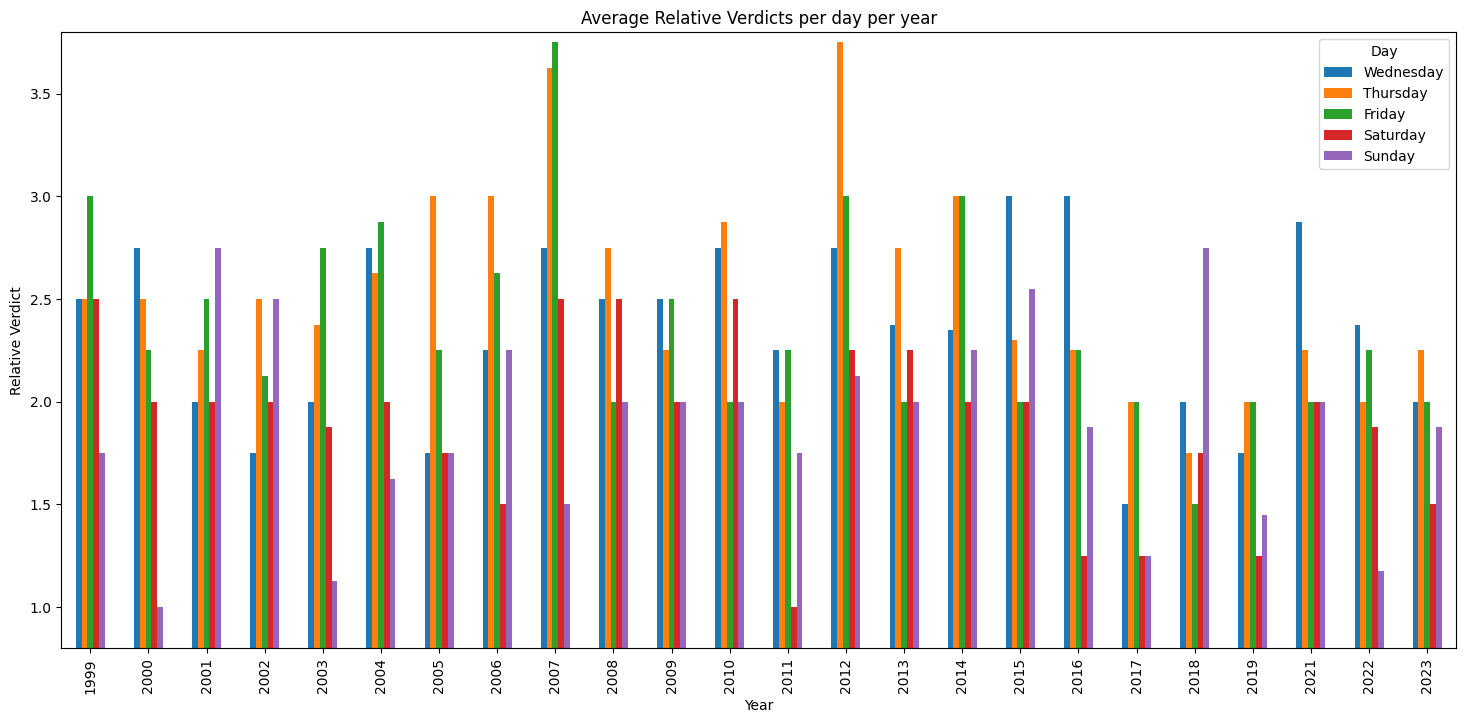

In [40]:
fig_3, ax_3a = mplt.subplots()
day_lengths_gb_tpd.plot(ax = ax_3a, kind = 'bar', figsize = (18,8), ylabel = 'Relative Verdict', ylim = (0.8, 3.8), title = 'Average Relative Verdicts per day per year')